In [1]:
from Helpers import main, make_dataloaders
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics import accuracy_score

In [2]:
# Load the BERT tokenizer and model for masked language modeling
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Load the RoBERTa tokenizer and model
tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
model_roberta = RobertaForMaskedLM.from_pretrained("roberta-base")

In [4]:
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")

Label 1: 5595 occurrences
Label 0: 2821 occurrences
Label 2: 1424 occurrences


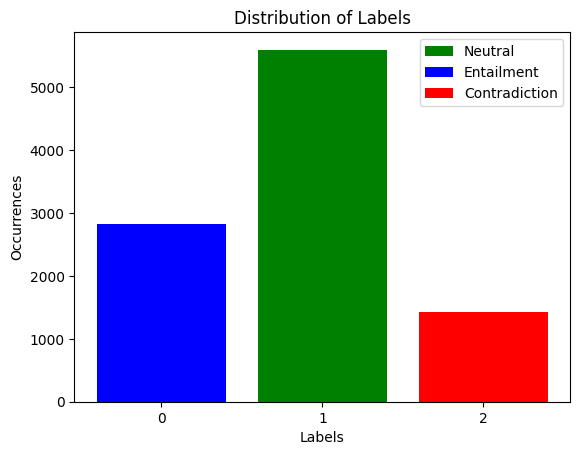

In [6]:
my_dataloader = make_dataloaders.my_dataloader
all_labels = make_dataloaders.all_labels
main.plot_distribution(all_labels)

In [13]:
models = [model_bert, model_roberta, model_gpt2]
tokenizers = [tokenizer_bert, tokenizer_roberta, tokenizer_gpt2]
probs_of_models_over_dateset = []
for i, (model,tokenizer) in enumerate(zip(models,tokenizers)):
    probs_over_dateset = main.prob_distribution_over_vocab_with_batch(model, tokenizer, my_dataloader)
    probs_of_models_over_dateset.append(probs_over_dateset)
    print("Finished model {}: {} \n".format(i+1, model.name_or_path.split("-")[0]))

Finished model 1: bert 

Finished model 2: roberta 

Finished model 3: gpt2 



In [7]:
results_bert_flattened = [inner_list for outer_list in probs_of_models_over_dateset[0] for inner_list in outer_list]
results_roberta_flattened = [inner_list for outer_list in probs_of_models_over_dateset[1] for inner_list in outer_list]
results_gpt2_flattened = [inner_list for outer_list in probs_of_models_over_dateset[2] for inner_list in outer_list]


predicted_labels = []
for item in results_gpt2_flattened:
    if item[0] > item[1] or item[0] > item[2]: # (true > false) and (true > unknown)
        predicted_labels.append(1) # append 0 for entailment 
    elif item[2] > item[0] and item[2] > item[1]: # (unknown > true) and (unknown > false)
        predicted_labels.append(1) # append 1 for neutral 
    else: 
        predicted_labels.append(2) # else append 2 for contradiction
    
print("The accuracy score is: {:.4f}".format(accuracy_score(all_labels, predicted_labels)))

The accuracy score is: 0.5655


### IRELEVANT PART #####

In [53]:
import torch 

tokens_of_interest = ["true", "false", "unknown"]
probs_over_batched_dataset = []
for batch in my_dataloader:
    sentences = [sentence.replace("[MASK]", '_') for sentence in batch['sentence']]
    tokenized_batch = tokenizer_gpt2(sentences)
    tokenized_batch = main.transform_pad_batch(tokenized_batch, model_gpt2)
    with torch.no_grad():
        outputs = model_gpt2(**tokenized_batch)
    mask_token_indicies = []
    
    for item in tokenized_batch["input_ids"]:
        mask_token_indicies.append(torch.where(item!=0)[0][-1].item())
    
    extracted_rows = outputs.logits[torch.arange(outputs.logits.size(0)), mask_token_indicies]
    probabilities = torch.functional.F.softmax(extracted_rows, dim=-1)
    print(probabilities.shape)
    inter_tokens_ids = main.get_interest_tokens(tokenizer_gpt2.get_vocab(), tokens_of_interest)
    print(inter_tokens_ids)
    probabilites_of_interest = probabilities[:, inter_tokens_ids]
    print(probabilites_of_interest)
    probs_over_batched_dataset.append(probabilites_of_interest.tolist())
    print(probs_over_batched_dataset)
    break

torch.Size([8, 50257])
[7942, 9562, 34680]
tensor([[3.5668e-05, 1.1464e-04, 1.9851e-06],
        [5.8537e-05, 1.3625e-04, 3.9739e-06],
        [5.9062e-05, 7.9166e-05, 2.5659e-06],
        [5.0147e-06, 1.1541e-05, 8.1211e-06],
        [4.0610e-06, 9.5627e-06, 1.1525e-05],
        [2.7224e-05, 9.9845e-05, 1.4174e-06],
        [7.0673e-05, 2.9570e-04, 3.2609e-06],
        [1.0684e-04, 3.0614e-04, 4.8399e-06]])
[[[3.566766463336535e-05, 0.0001146413924288936, 1.9850749595207162e-06], [5.853661059518345e-05, 0.00013624713756144047, 3.973904767917702e-06], [5.9062065702164546e-05, 7.916623872006312e-05, 2.5659082893980667e-06], [5.0147205001849215e-06, 1.1540716513991356e-05, 8.12108555692248e-06], [4.061021627421724e-06, 9.562720151734538e-06, 1.1524550245667342e-05], [2.722367935348302e-05, 9.984481584979221e-05, 1.4174349871609593e-06], [7.067287515383214e-05, 0.00029569503385573626, 3.2609041227260605e-06], [0.00010684038716135547, 0.0003061415336560458, 4.83985149912769e-06]]]
